# Лабораторная работа №3
## Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей 

## Задание:
1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
3. Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью подходящих для задачи метрик.
4. Произведите подбор гиперпараметра K с использованием GridSearchCV и/или RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели. Желательно использование нескольких стратегий кросс-валидации.
5. Сравните метрики качества исходной и оптимальной моделей.

In [374]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score 
from typing import Dict, Tuple
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

В качестве датасета выберем набор данных о фруктах

https://www.kaggle.com/datasets/mjamilmoughal/fruits-with-colors-dataset

In [392]:
data = pd.read_csv("fruit_data_with_colors.txt", sep = '\s+')
data.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


In [7]:
#проверим наличие нулевых значений
data.isnull().sum()

fruit_label      0
fruit_name       0
fruit_subtype    0
mass             0
width            0
height           0
color_score      0
dtype: int64

In [73]:
#разделим выборку на обучающую и тестовую
fruit_x_train, fruit_x_test, fruit_y_train, fruit_y_test = train_test_split(
    data[["mass","width","height","color_score"]],
    data[['fruit_label']], test_size = 0.2, random_state = 1)

In [82]:
fruit_x_train.shape, fruit_x_test.shape

((47, 4), (12, 4))

In [84]:
fruit_y_train.shape, fruit_y_test.shape

((47, 1), (12, 1))

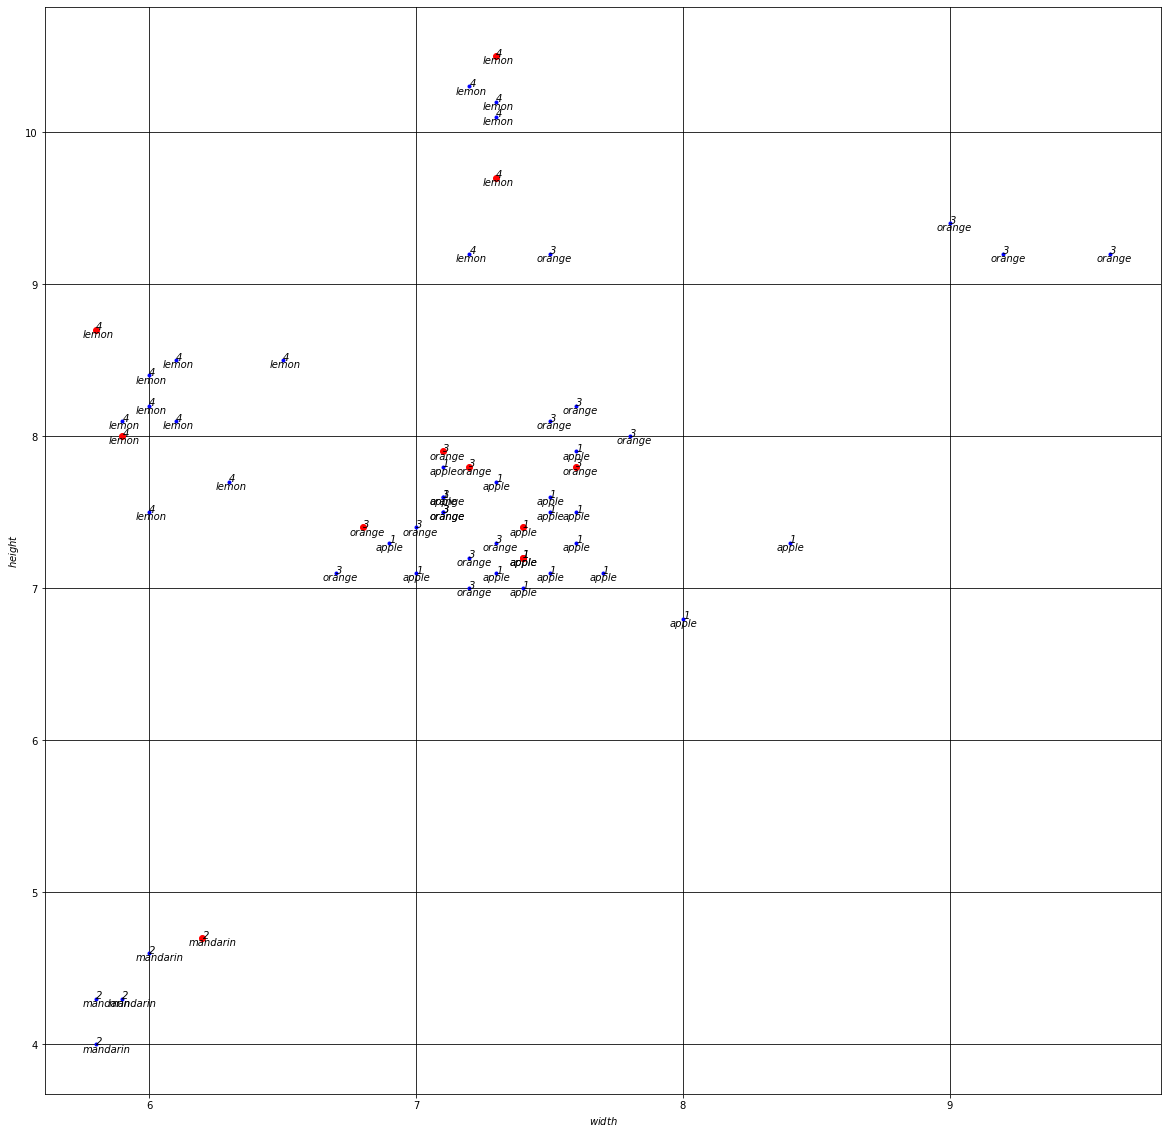

In [68]:
# визуализация выборки
fig, ax = plt.subplots(figsize=(20,20))

ax.plot(fruit_x_train['width'], fruit_x_train['height'], 'b.', \
         fruit_x_test['width'], fruit_x_test['height'], 'ro')

# деления на осях и сетка
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.grid(which='major', color = 'k')

# подписи к осям
plt.xlabel('$width$')
plt.ylabel('$height$')
   
# подписи 
for coords in data[['width','height', 'fruit_label', 'fruit_name']].values:
    x1, x2, fruit_label, fruit_name = coords[0], coords[1], coords[2], coords[3]
    #label = '{} ({})'.format(y_cl, cl)
    #ax.text(x1 + 0.1, x2, label, style='italic', fontsize=7)
    ax.text(x1-0.05, x2-0.05, fruit_name, style='italic', fontsize=10)
    ax.text(x1, x2, fruit_label, style='italic', fontsize=10)

plt.show()  

### С помощью метода ближайших соседей KNN будем решать задачу классификации

In [313]:
# 3 ближайших соседа
cl1 = KNeighborsClassifier(n_neighbors=3)
cl1.fit(fruit_x_train[["width","height"]], fruit_y_train.values.ravel())#?
target1 = cl1.predict(fruit_x_test[["width","height"]])
target1_2 = cl1.predict(fruit_x_train[["width","height"]])
len(target1), target1

(12, array([4, 1, 1, 4, 3, 1, 1, 1, 1, 4, 4, 2], dtype=int64))

In [314]:
# 7 ближайших соседа
cl2 = KNeighborsClassifier(n_neighbors=7)
cl2.fit(fruit_x_train[["width","height"]], fruit_y_train.values.ravel())#?
target2 = cl2.predict(fruit_x_test[["width","height"]])
target2_2 = cl2.predict(fruit_x_train[["width","height"]])
len(target2), target2

(12, array([4, 1, 3, 4, 3, 1, 1, 1, 1, 4, 4, 2], dtype=int64))

Проверим качество модели с помощью метрик классификации
    
##### Accuracy

In [319]:
#для 3 ближайших соседей
accuracy_score(fruit_y_test, target1), accuracy_score(fruit_y_train, target1_2)

(0.75, 0.8936170212765957)

In [320]:
#для 7 ближайших соседей
accuracy_score(fruit_y_test, target2), accuracy_score(fruit_y_train, target2_2)

(0.8333333333333334, 0.8085106382978723)

In [361]:
accuracy = []
accuracy.append(accuracy_score(fruit_y_test, target1))
accuracy.append(accuracy_score(fruit_y_train, target1_2))
accuracy.append(accuracy_score(fruit_y_test, target2))
accuracy.append(accuracy_score(fruit_y_train, target2_2))
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [362]:
#Сравним также Accuracy для разных классов
#при К = 3
print_accuracy_score_for_classes(fruit_y_test["fruit_label"], target1)

Метка 	 Accuracy
1 	 1.0
2 	 1.0
3 	 0.25
4 	 1.0


In [363]:
#при K = 7
print_accuracy_score_for_classes(fruit_y_test["fruit_label"], target2)

Метка 	 Accuracy
1 	 1.0
2 	 1.0
3 	 0.5
4 	 1.0


##### Confusion matrix, Precision, Recall, F-мера

In [181]:
confusion_matrix(fruit_y_test, target1, labels=[1, 2, 3, 4])

array([[3, 0, 0, 0],
       [0, 1, 0, 0],
       [3, 0, 1, 0],
       [0, 0, 0, 4]], dtype=int64)

In [182]:
confusion_matrix(fruit_y_test, target2, labels=[1, 2, 3, 4])

array([[3, 0, 0, 0],
       [0, 1, 0, 0],
       [2, 0, 2, 0],
       [0, 0, 0, 4]], dtype=int64)

Как видно из примеров выше при K=7 алгоритм ошибочно определил 2 точки класса 3 были ошибочно определены как точки класса 1
Посчитаем Precision, Recall, F-меру для K=3 и K=7

In [185]:
#K=3
precision_score(fruit_y_test, target1, average = 'micro'), recall_score(fruit_y_test, target1, average = 'micro')

(0.75, 0.75)

In [186]:
precision_score(fruit_y_test, target1, average = 'macro'), recall_score(fruit_y_test, target1, average = 'macro')

(0.875, 0.8125)

In [187]:
precision_score(fruit_y_test, target1, average = 'weighted'), recall_score(fruit_y_test, target1, average = 'weighted')

(0.875, 0.75)

In [195]:
#K=7
precision_score(fruit_y_test, target2, average = 'micro'), recall_score(fruit_y_test, target2, average = 'micro')

(0.8333333333333334, 0.8333333333333334)

In [196]:
precision_score(fruit_y_test, target2, average = 'macro'), recall_score(fruit_y_test, target2, average = 'macro')

(0.9, 0.875)

In [197]:
precision_score(fruit_y_test, target2, average = 'weighted'), recall_score(fruit_y_test, target2, average = 'weighted')b

(0.9, 0.8333333333333334)

In [201]:
#f1_score для K=3 и K=7
f1_score(fruit_y_test, target1, average = 'weighted'), f1_score(fruit_y_test, target2, average = 'weighted')

(0.7166666666666667, 0.8263888888888888)

In [212]:
classification_report(fruit_y_test, target1, target_names = ["apple", "mandarin", "orange", "lemon"], output_dict = True)

{'apple': {'precision': 0.5,
  'recall': 1.0,
  'f1-score': 0.6666666666666666,
  'support': 3},
 'mandarin': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1},
 'orange': {'precision': 1.0, 'recall': 0.25, 'f1-score': 0.4, 'support': 4},
 'lemon': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 4},
 'accuracy': 0.75,
 'macro avg': {'precision': 0.875,
  'recall': 0.8125,
  'f1-score': 0.7666666666666666,
  'support': 12},
 'weighted avg': {'precision': 0.875,
  'recall': 0.75,
  'f1-score': 0.7166666666666667,
  'support': 12}}

In [213]:
classification_report(fruit_y_test, target2, target_names = ["apple", "mandarin", "orange", "lemon"], output_dict = True)

{'apple': {'precision': 0.6,
  'recall': 1.0,
  'f1-score': 0.7499999999999999,
  'support': 3},
 'mandarin': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1},
 'orange': {'precision': 1.0,
  'recall': 0.5,
  'f1-score': 0.6666666666666666,
  'support': 4},
 'lemon': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 4},
 'accuracy': 0.8333333333333334,
 'macro avg': {'precision': 0.9,
  'recall': 0.875,
  'f1-score': 0.8541666666666666,
  'support': 12},
 'weighted avg': {'precision': 0.9,
  'recall': 0.8333333333333334,
  'f1-score': 0.8263888888888888,
  'support': 12}}

## Подбор гиперпараметра с помощью кросс-валидации
Найдём наилучший гиперпараметр используя текущую перестановку

##### KFold()

In [333]:
kf = KFold(n_splits=10)
r = np.array(range(1,20))
params = [{"n_neighbors": r}]
gs = GridSearchCV(KNeighborsClassifier(), params, cv=kf, scoring="accuracy")
gs.fit(fruit_x_train[["width","height"]], fruit_y_train.values.ravel())

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])}],
             scoring='accuracy')

In [334]:
gs.best_estimator_

KNeighborsClassifier(n_neighbors=3)

In [335]:
gs.best_score_

0.8300000000000001

In [336]:
gs.best_params_

{'n_neighbors': 3}

In [337]:
#gs.cv_results_

Text(0.5, 1.0, 'Гиперпараметр при KFold()')

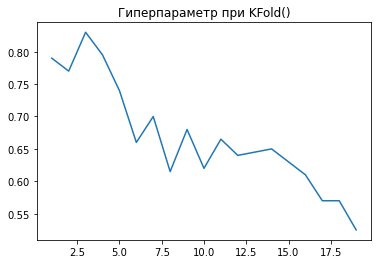

In [338]:
plt.plot(r, gs.cv_results_['mean_test_score'])
plt.title("Гиперпараметр при KFold()")

In [340]:
#Предсказание резульатов на тестовой и обучающей выборках
gs.best_estimator_.fit(fruit_x_train[["width","height"]], fruit_y_train.values.ravel())
predGs1 = gs.best_estimator_.predict(fruit_x_test[["width","height"]])
predGs2 = gs.best_estimator_.predict(fruit_x_train[["width","height"]])
predGs1, fruit_y_test.values.ravel(),predGs2, fruit_y_train.values.ravel()

(array([4, 1, 1, 4, 3, 1, 1, 1, 1, 4, 4, 2], dtype=int64),
 array([4, 1, 3, 4, 3, 3, 3, 1, 1, 4, 4, 2], dtype=int64),
 array([3, 3, 3, 1, 4, 3, 4, 3, 3, 4, 4, 4, 4, 3, 1, 3, 4, 3, 1, 4, 3, 3,
        2, 1, 3, 1, 4, 3, 1, 4, 1, 3, 2, 4, 2, 4, 1, 1, 1, 1, 2, 3, 1, 1,
        1, 4, 3], dtype=int64),
 array([3, 3, 3, 1, 4, 3, 4, 3, 3, 4, 3, 4, 4, 3, 1, 1, 4, 3, 1, 4, 3, 1,
        2, 1, 3, 3, 4, 3, 1, 4, 1, 3, 2, 4, 2, 4, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 4, 3], dtype=int64))

In [369]:
#Оценка качества с помощью Accuracy
accuracy.append(accuracy_score(fruit_y_test, predGs1))
accuracy.append(accuracy_score(fruit_y_train, predGs2))
accuracy[4], accuracy[5]

(0.75, 0.8936170212765957)

##### StratifiedShuffleSplit()

In [342]:
kf = StratifiedShuffleSplit(n_splits=10, test_size = 0.2)
r = np.array(range(1,20))
params = [{"n_neighbors": r}]
gs2= GridSearchCV(KNeighborsClassifier(), params, cv=kf, scoring="accuracy")
gs2.fit(fruit_x_train[["width","height"]], fruit_y_train.values.ravel())

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.2,
            train_size=None),
             estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])}],
             scoring='accuracy')

In [343]:
gs2.best_estimator_

KNeighborsClassifier(n_neighbors=3)

In [345]:
gs2.best_score_

0.85

In [346]:
gs2.best_params_

{'n_neighbors': 3}

In [347]:
#gs2.cv_results_

Text(0.5, 1.0, 'Гиперпараметр при StratifiedShuffleSplit()')

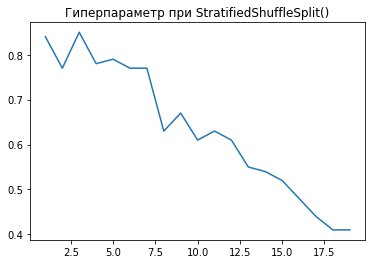

In [348]:
plt.plot(r, gs2.cv_results_['mean_test_score'])
plt.title("Гиперпараметр при StratifiedShuffleSplit()")

In [349]:
#Предсказание резульатов на тестовой и обучающей выборках
gs2.best_estimator_.fit(fruit_x_train[["width","height"]], fruit_y_train.values.ravel())
predGs1 = gs2.best_estimator_.predict(fruit_x_test[["width","height"]])
predGs2 = gs2.best_estimator_.predict(fruit_x_train[["width","height"]])
predGs1, fruit_y_test.values.ravel(),predGs2, fruit_y_train.values.ravel()

(array([4, 1, 1, 4, 3, 1, 1, 1, 1, 4, 4, 2], dtype=int64),
 array([4, 1, 3, 4, 3, 3, 3, 1, 1, 4, 4, 2], dtype=int64),
 array([3, 3, 3, 1, 4, 3, 4, 3, 3, 4, 4, 4, 4, 3, 1, 3, 4, 3, 1, 4, 3, 3,
        2, 1, 3, 1, 4, 3, 1, 4, 1, 3, 2, 4, 2, 4, 1, 1, 1, 1, 2, 3, 1, 1,
        1, 4, 3], dtype=int64),
 array([3, 3, 3, 1, 4, 3, 4, 3, 3, 4, 3, 4, 4, 3, 1, 1, 4, 3, 1, 4, 3, 1,
        2, 1, 3, 3, 4, 3, 1, 4, 1, 3, 2, 4, 2, 4, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 4, 3], dtype=int64))

In [370]:
#Оценка качества с помощью Accuracy
accuracy.append(accuracy_score(fruit_y_test, predGs1))
accuracy.append(accuracy_score(fruit_y_train, predGs2))
accuracy[6], accuracy[7]

(0.75, 0.8936170212765957)

### Сравним метрики качества исходной и оптимальных моделей

<AxesSubplot:title={'center':'Сравнение предсказания всех моделей'}, xlabel='Marks', ylabel='Accuracy'>

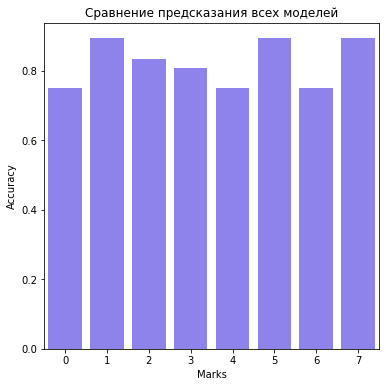

In [391]:
#По четным test, по нечетным train
#Исходная модель для K=3 - это 0,1
#Исходная модель для K=7 - это 2,3
#Модели, найденные с помощью KFold и StratifiedShuffleSplit 4,5 и 6,7 соответственно. K в обоих случаях получился = 3
X = [i for i in range(len(accuracy))]
dataframe = pd.DataFrame({"Marks": X, "Accuracy": accuracy})
fig, ax = plt.subplots(figsize=(6,6)) 
ax.title.set_text("Сравнение предсказания всех моделей")
sns.barplot(data=dataframe, y="Accuracy", x="Marks", color="#8172fb")